[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LorenzoRimella/TF_intro/blob/main/track_tensorflow.ipynb)

## Tracciare operazioni

Iniziamo con l'importare le librerie principali. La libreria tensorflow è l'oggetto della presentazione, numpy verrà usata per un confronto, time per calcolare i running times, e matplotlib per i grafici.

In [23]:
import tensorflow as tf

import numpy as np

import time

import matplotlib.pyplot as plt

Vediamo se abbiamo una GPU disponibile

In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Funzione in TensoFlow

Basta eseguire le stesse operazioni per creare una funzione in Python ma usando i tensori.

In [26]:
def target(x):

	return 3*x*x

x = tf.convert_to_tensor([100], tf.float32)

print("La funzione in 100 vale"+"\n", target(x))

La funzione in 100 vale
 tf.Tensor([30000.], shape=(1,), dtype=float32)


Disegnamo la funzione

Text(0.98, 0.02, '$y=3x^2$')

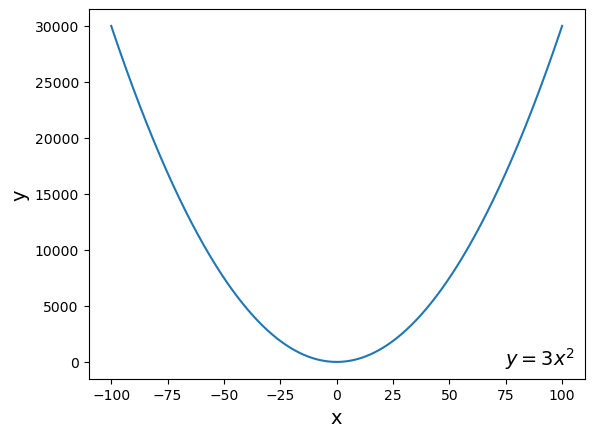

In [32]:
x_linspace = tf.linspace(-100, 100, 10000)

plt.plot(x_linspace, target(x_linspace))

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)

plt.text(
    0.98, 0.02, r"$y=3x^2$",
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    fontsize=14
)

Per tracciare le operazioni possiamo utilizzare tf.Variable.

In [83]:
x_var = tf.Variable(x)

print("Tensore come una variabile"+"\n", x_var)

Tensore come una variabile
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([100.], dtype=float32)>


Ovviamente tracciare le operazioni è costoso, quindi dobbiamo specificarlo in maniera explicita.

In [84]:
with tf.GradientTape() as tape:
	y = target(x_var)

dy_dx = tape.gradient(y, [x_var])

print("La derivata (gradiente) in 100 vale"+"\n", dy_dx)

La derivata (gradiente) in 100 vale
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([600.], dtype=float32)>]


Una volta che sappiamo come calcolare il gradiente possiamo buttare tutto dentro un ottimizatore per trovare il minimo.

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2)

grad_steps = 200

y_history = []
x_history = []

for steps in range(grad_steps):

	with tf.GradientTape() as tape:
		y = target(x_var)

	y_history.append(y.numpy())
	x_history.append(x_var.numpy())

	# Compute gradient
	grad = tape.gradient(y, [x_var])

	# Apply Adam update
	optimizer.apply_gradients(zip(grad, [x_var]))



(-0.5, 1.0)

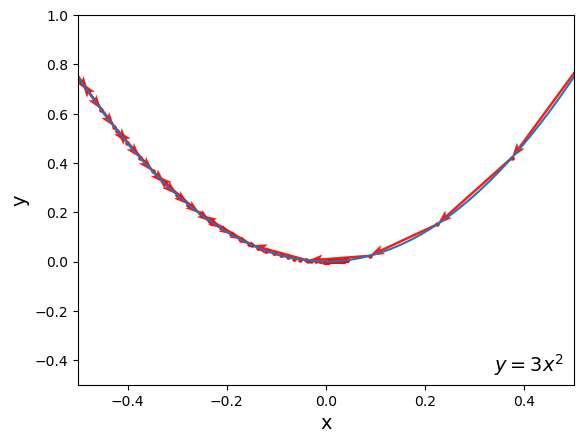

In [91]:
x_linspace = tf.linspace(-100, 100, 10000)

plt.plot(x_linspace, target(x_linspace))
plt.scatter

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)

plt.text(
    0.98, 0.02, r"$y=3x^2$",
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    fontsize=14
)

# create arrays and collapse dimension with .ravel()
x_hist = np.asarray(x_history, dtype=float).ravel()
y_hist = np.asarray(y_history, dtype=float).ravel()

# arrows vectors
dx = x_hist[1:] - x_hist[:-1]
dy = y_hist[1:] - y_hist[:-1]

plt.quiver(
    x_hist[:-1], y_hist[:-1],   # start points
    dx, dy,                     # arrow vectors
    angles='xy', scale_units='xy', scale=1,
    width=0.005, headwidth=4, headlength=6, headaxislength=5,
    alpha=0.9, color = "red"
)

plt.scatter(x_hist, y_hist, s=5, color = "red")

plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1) 

<!-- ## Operazioni tra tensori -->

### Regressione Lineare

Possiamo costruire il nostro problema di regressione lineare come un problema di ottimizzazione della likelihood

In [129]:
import pandas as pd
import os

import kagglehub
from kagglehub import KaggleDatasetAdapter

path = kagglehub.dataset_download("karthickveerakumar/startup-logistic-regression")

df = pd.read_csv(path+"/"+os.listdir(path)[0])
df = df.drop(columns=["State"])

print("Le prime righe dei dati sono "+"\n", df.head())

X_n = df[["R&D Spend", "Administration", "Marketing Spend"]].values.astype(float)
Y_n = df[["Profit"]].values.astype(float)[:,0]

Le prime righe dei dati sono 
    R&D Spend  Administration  Marketing Spend     Profit
0  165349.20       136897.80        471784.10  192261.83
1  162597.70       151377.59        443898.53  191792.06
2  153441.51       101145.55        407934.54  191050.39
3  144372.41       118671.85        383199.62  182901.99
4  142107.34        91391.77        366168.42  166187.94


Inziamo a convertire tutto in tensori e a calcolare la soluzione OLS

In [132]:
X_n = tf.convert_to_tensor(X_n, tf.float32)
Y_n = tf.convert_to_tensor(Y_n, tf.float32)

hatbeta = tf.einsum("ij,j->i", tf.linalg.inv(tf.einsum("ni,nk->ik", X_n, X_n)), tf.einsum("ni,n->i", X_n, Y_n))

print("La soluzione OLS è "+"\n", hatbeta)

La soluzione OLS è 
 tf.Tensor([0.7179513  0.32769513 0.0821799 ], shape=(3,), dtype=float32)


Vediamo ora cosa succede se ottimiziamo la log-likelihood

In [148]:
X_n = tf.convert_to_tensor(X_n, tf.float32)
Y_n = tf.convert_to_tensor(Y_n, tf.float32)

def log_likelihood_linear_regression(X, Y, beta, sigma):

	pi = tf.cast(np.pi, tf.float32)
	n = tf.cast(tf.shape(X)[0], tf.float32)
	X_beta = tf.einsum("ni,i->n", X, beta) 

	return -(n/2)*tf.math.log(2*pi*tf.math.pow(sigma, 2)) - tf.reduce_sum(tf.math.pow(Y - X_beta, 2)/(2*tf.math.pow(sigma, 2)))

beta_grad = tf.Variable(tf.convert_to_tensor([1, 1, 1], tf.float32))
sigma = tf.convert_to_tensor([1], tf.float32)

print("La soluzione OLS ha una log-likelihood di "+"\n", log_likelihood_linear_regression(X_n, Y_n, hatbeta,   sigma))
print("La condizione di partenza ha una log-likelihood di "+"\n", log_likelihood_linear_regression(X_n, Y_n, beta_grad, sigma))

La soluzione OLS ha una log-likelihood di 
 tf.Tensor([-4.4390574e+09], shape=(1,), dtype=float32)
La condizione di partenza ha una log-likelihood di 
 tf.Tensor([-2.568258e+12], shape=(1,), dtype=float32)


In [149]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

grad_steps = 1000

n = tf.cast(tf.shape(X_n)[0], tf.float32)

log_like_history = []
beta_history = []

for steps in range(grad_steps):

	with tf.GradientTape() as tape:
		loss = -log_likelihood_linear_regression(X_n, Y_n, beta_grad, sigma)/n

	log_like_history.append((-n*loss).numpy())
	beta_history.append(beta_grad.numpy())

	# Compute gradient
	grad = tape.gradient(loss, [beta_grad])

	# Apply Adam update
	optimizer.apply_gradients(zip(grad, [beta_grad]))

Text(0, 0.5, '$\\beta$')

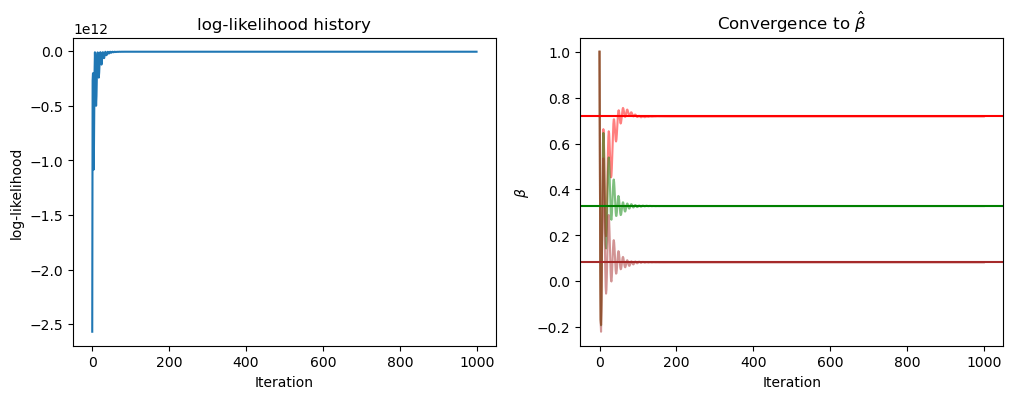

In [156]:
log_like = np.asarray(log_like_history, dtype=float)

beta_hist = np.asarray(beta_history, dtype=float)   
hatbeta = np.asarray(hatbeta, dtype=float).reshape(3,)

t = np.arange(len(log_like))

dist = np.linalg.norm(beta_hist - hatbeta[None, :], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (1) Loss / log-likelihood history
axes[0].plot(t, log_like)
axes[0].set_title("log-likelihood history")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("log-likelihood" if "log_like" in "log_like" else "Objective")

# (2) Convergence to OLS hatbeta
axes[1].plot(t, beta_hist[:,0], color = "red", alpha = 0.5)
axes[1].plot(t, beta_hist[:,1], color = "green", alpha = 0.5)
axes[1].plot(t, beta_hist[:,2], color = "brown", alpha = 0.5)

axes[1].axhline(y= hatbeta[0], color = "red")
axes[1].axhline(y= hatbeta[1], color = "green")
axes[1].axhline(y= hatbeta[2], color = "brown")

axes[1].set_title(r"Convergence to $\hat{\beta}$")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel(r"$\beta$")